# mT5

In [19]:
from datasets import load_dataset, concatenate_datasets, load_from_disk, Dataset, DatasetDict
from transformers import MT5TokenizerFast

import re, glob, random
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

from data_utils.utils import *

In [20]:
MAX_LENGTH = 1024
model_id = 'google/mt5-base'

In [21]:
# Setup tokenizer
tokenizer = MT5TokenizerFast.from_pretrained(model_id)

print('BOS:', tokenizer.bos_token)
print('SEP:', tokenizer.sep_token)
print('PAD:', tokenizer.pad_token)
print('EOS:', tokenizer.eos_token)

/home/nlp/anaconda3/envs/vietnq-ner/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


BOS: None
SEP: None
PAD: <pad>
EOS: </s>


### 1. Dataset open-domain NER: `Universal-NER/Pile-NER-type`

#### Load dataset

In [4]:
# output repo in huggingface
output_repo = 'en-mT5-ner-open_domain'

split_ratio = 0.1
random_seed = 42

In [5]:
en_open_ner = load_dataset('Universal-NER/Pile-NER-type', split='train')
en_open_ner

Dataset({
    features: ['conversations', 'id'],
    num_rows: 45889
})

In [6]:
en_open_ner[232]

{'conversations': [{'from': 'human',
   'value': 'Text: N-(X-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide (with X = 2 and 4). The structures of N-(2-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide and N-(4-chlorophenyl)-4-hydroxy-2-methyl-2H-1,2-benzothiazine-3-carboxamide 1,1-dioxide, both C16H13ClN2O4S, are stabilized by extensive intramolecular hydrogen bonds. The 4-chloro derivative forms dimeric pairs of molecules lying about inversion centres as a result of intermolecular N-H...O hydrogen bonds, forming 14-membered rings representing an R2(2)(14) motif; the 2-chloro derivative is devoid of any such intermolecular hydrogen bonds. The heterocyclic thiazine rings in both structures adopt half-chair conformations.'},
  {'from': 'gpt', 'value': "I've read this text."},
  {'from': 'human', 'value': 'What describes Relationship in the text?'},
  {'from': 'gpt', 'value': '[]'},
  {'from': 'human', 'value': 'What describes

Split into train/test sets

In [7]:
print(f"> Split dataset with ratio {split_ratio}:")
en_open_ner_splitted = en_open_ner.train_test_split(
    test_size=split_ratio, seed=random_seed
)
print("\tNo. train samples:", en_open_ner_splitted.shape["train"][0])
print("\tNo. test samples: ", en_open_ner_splitted.shape["test"][0])

> Split dataset with ratio 0.1:
	No. train samples: 41300
	No. test samples:  4589


#### Make instruction dataset

In [8]:
# Make instruction data
def make_instruction_data(samples):
    ids, texts, labels, entity_types, input_paras = [], [], [], [], []

    for sample_id, sample_conv in zip(samples['id'], samples['conversations']):
        cur_input_para = sample_conv[0]['value'].strip()
        for i in range(2, len(sample_conv), 2):
            cur_id = str(sample_id) + '_' + str(i//2)

            user_question = sample_conv[i]['value'].strip()
            cur_entity_type = re.search(r'(?<=describes\s)(.*?)(?=\sin)', user_question).group(0).strip()
            cur_instruction = user_question.replace(cur_entity_type, cur_entity_type.lower())
            cur_text = prompt_input({
                'instruction': cur_instruction,
                'input': cur_input_para,
            })

            cur_label = sample_conv[i+1]['value'].strip()

            ids.append(cur_id)
            texts.append(cur_text)
            labels.append(cur_label)
            entity_types.append(cur_entity_type)
            input_paras.append(cur_input_para)
    return {
        'id': ids,
        'text': texts,
        'label': labels,
        'entity_type': entity_types,
        'input_para': input_paras,
    }

print("> Making instruction dataset...")
en_open_ner_instruct = en_open_ner_splitted.map(
    make_instruction_data, batched=True, remove_columns=en_open_ner_splitted['train'].column_names
)
print("Instruction dataset:", en_open_ner_instruct)

> Making instruction dataset...
Instruction dataset: DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'entity_type', 'input_para'],
        num_rows: 321753
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'entity_type', 'input_para'],
        num_rows: 36428
    })
})


#### Clean dataset

In [9]:
df_train_raw = en_open_ner_instruct['train'].to_pandas()
df_test_raw = en_open_ner_instruct['test'].to_pandas()

# combine train and test data, distinguish by 'split' column
df_train_raw['split'] = 'train'
df_test_raw['split'] = 'test'
df_raw = pd.concat([df_train_raw, df_test_raw], ignore_index=True)
df_raw

,id,text,label,entity_type,input_para,split
0,ner_1275_1,"Below is an instruction that describes a task,...","[""Byzantine"", ""Fatimid Caliphate"", ""Song""]",Organization,Text: 975\n\nYear 975 (CMLXXV) was a common ye...,train
1,ner_1275_2,"Below is an instruction that describes a task,...",[],Brand,Text: 975\n\nYear 975 (CMLXXV) was a common ye...,train
2,ner_1275_3,"Below is an instruction that describes a task,...",[],parameter,Text: 975\n\nYear 975 (CMLXXV) was a common ye...,train
3,ner_1275_4,"Below is an instruction that describes a task,...","[""Mesopotamia"", ""Marca Obertenga"", ""Eastern Li...",Region,Text: 975\n\nYear 975 (CMLXXV) was a common ye...,train
4,ner_1275_5,"Below is an instruction that describes a task,...",[],license,Text: 975\n\nYear 975 (CMLXXV) was a common ye...,train
...,...,...,...,...,...,...
358176,ner_23027_3,"Below is an instruction that describes a task,...","[""http://www.boost.org/LICENSE_1_0.txt"", ""http...",url,Text: //--------------------------------------...,test
358177,ner_23027_4,"Below is an instruction that describes a task,...","[""Boost Software License""]",license,Text: //--------------------------------------...,test
358178,ner_28056_1,"Below is an instruction that describes a task,...","[""Betsy Mikel""]",Person,Text: Are Women to Blame for Making Less Money...,test
358179,ner_28056_2,"Below is an instruction that describes a task,...","[""Women 2.0"", ""Babson College"", ""Goldman Sachs...",Organization,Text: Are Women to Blame for Making Less Money...,test


In [10]:
type(df_raw['label'][0])

str

Normalize the entity types by set all entity types to lowercase

In [11]:
df = df_raw.copy()
df['entity_type_lower'] = df['entity_type'].str.lower()

In [12]:
# Befor normalize
counts = df['entity_type'].value_counts(sort=True)
counts.size, counts[:20]

(15461,
 entity_type
 person          13706
 Person          11857
 organization    11831
 Organization    11157
 location        10196
 Location         9479
 concept          7523
 Date             6304
 product          6262
 date             5071
 event            3773
 group            3701
 technology       3463
 Event            3032
 object           3015
 software         2892
 Product          2821
 measurement      2624
 Nationality      2571
 variable         2522
 Name: count, dtype: int64)

In [13]:
# After normalize
counts = df['entity_type_lower'].value_counts(sort=True)
counts.size, counts[:20]

(12870,
 entity_type_lower
 person               25929
 organization         23231
 location             19888
 date                 11742
 concept               9908
 product               9178
 event                 6887
 technology            4866
 group                 4530
 medical condition     3853
 nationality           3610
 object                3602
 software              3502
 disease               3212
 measurement           3131
 time                  2954
 title                 2851
 country               2757
 variable              2670
 process               2561
 Name: count, dtype: int64)

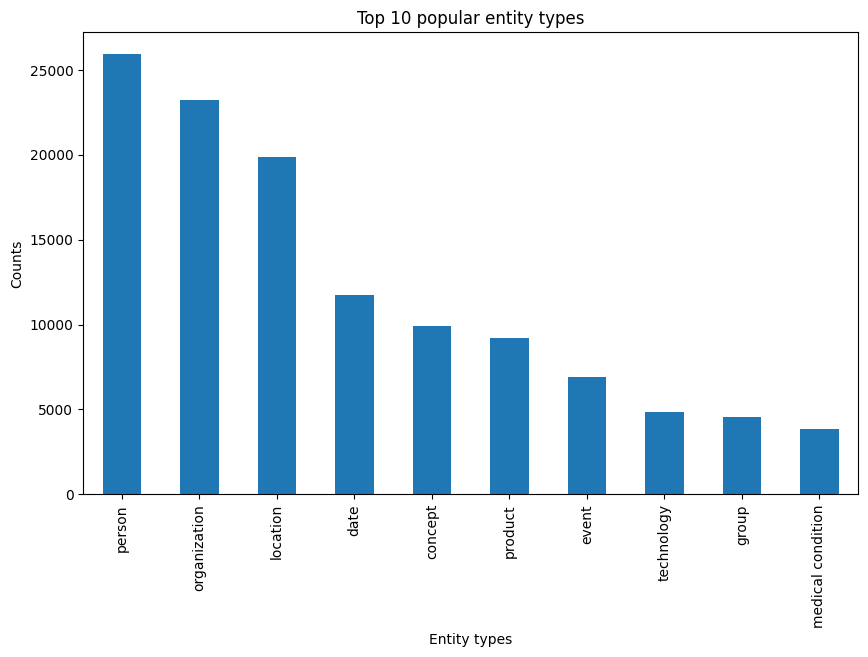

In [14]:
# Plot a bar chat of top 10 popular entity types
plt.figure(figsize=(10, 6))
counts[:10].plot(kind='bar')
plt.title('Top 10 popular entity types')
plt.ylabel('Counts')
plt.xlabel('Entity types')
plt.show()

In [15]:
# No negative examples vs total
df[df['label'] == '[]'].shape[0], df.shape[0]

(119862, 358181)

In [16]:
cleaned_df = df.drop_duplicates(subset=['input_para', 'entity_type_lower', 'label'])
df.shape, cleaned_df.shape

((358181, 7), (354402, 7))

In [17]:
en_open_ner_cleaned = DatasetDict({
    'train': Dataset.from_pandas(cleaned_df[cleaned_df['split'] == 'train'][['id', 'text', 'label']], preserve_index=False),
    'test': Dataset.from_pandas(cleaned_df[cleaned_df['split'] == 'test'][['id', 'text', 'label']], preserve_index=False),
})
en_open_ner_cleaned

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 318370
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 36032
    })
})

#### Convey the lengths of samples in dataset

Map: 100%|██████████| 36032/36032 [00:04<00:00, 7700.13 examples/s]


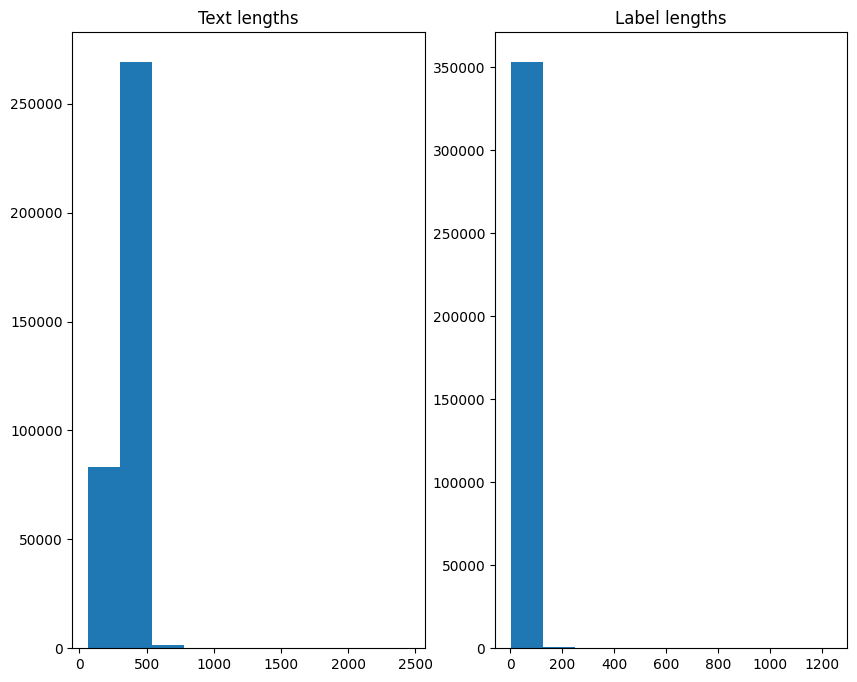

Max text length: 2449
Max label length: 1237
Current limit: MAX_LENGTH = 1024


In [18]:
en_open_ner_cleaned_with_length = en_open_ner_cleaned.map(
    lambda samples: {
        'len_text': [len(x) for x in tokenizer(samples['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
        'len_label': [len(x) for x in tokenizer(samples['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
    },
    batched=True
)

text_lengths = en_open_ner_cleaned_with_length['train']['len_text'] + en_open_ner_cleaned_with_length['test']['len_text']
label_lengths = en_open_ner_cleaned_with_length['train']['len_label'] + en_open_ner_cleaned_with_length['test']['len_label']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(text_lengths)
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(label_lengths)
plt.title('Label lengths')

plt.show()

print('Max text length:', max(text_lengths))
print('Max label length:', max(label_lengths))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

Drop those samples that having lengths exceed the pre-defined MAX LENGTH

In [19]:
en_open_ner_cleaned_dropped = en_open_ner_cleaned_with_length.filter(
    lambda example: (example['len_text'] <= MAX_LENGTH) and (example['len_label'] <= MAX_LENGTH)
)

Filter: 100%|██████████| 36032/36032 [00:00<00:00, 265080.28 examples/s]


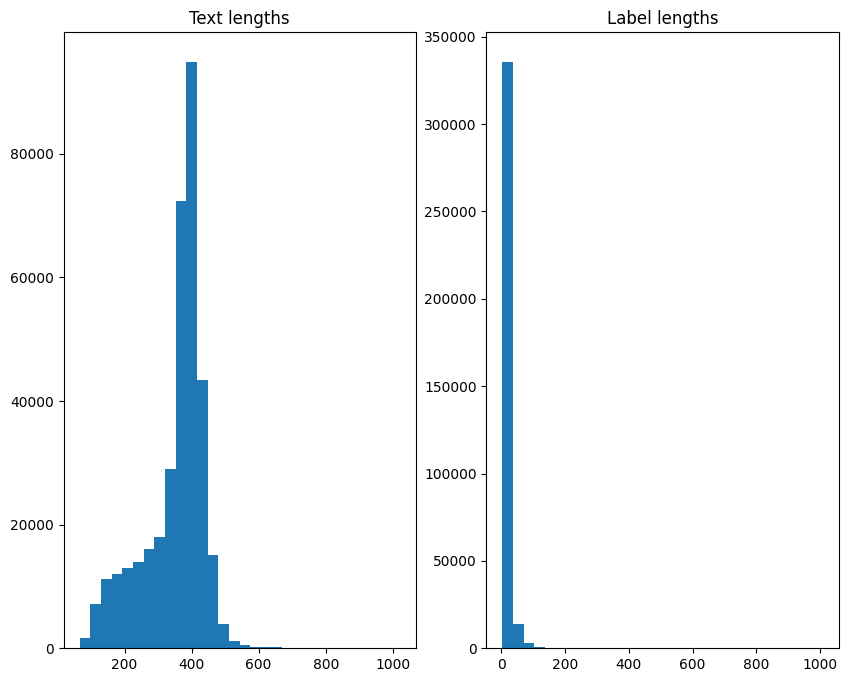

Max text length: 1021
Max label length: 1008
Current limit: MAX_LENGTH = 1024


In [20]:
text_lengths = en_open_ner_cleaned_dropped['train']['len_text'] + en_open_ner_cleaned_dropped['test']['len_text']
label_lengths = en_open_ner_cleaned_dropped['train']['len_label'] + en_open_ner_cleaned_dropped['test']['len_label']

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=30)
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(label_lengths, bins=30)
plt.title('Label lengths')

plt.show()

print('Max text length:', max(text_lengths))
print('Max label length:', max(label_lengths))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

In [21]:
en_open_ner_cleaned_dropped

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'len_text', 'len_label'],
        num_rows: 318261
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'len_text', 'len_label'],
        num_rows: 36000
    })
})

#### Create tokenized dataset

In [22]:
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
en_open_ner_tokenized = en_open_ner_cleaned_dropped.map(
    lambda x: tokenize(x, tokenizer, "text", "label"),
    batched=True,
    remove_columns=["text", "label", "len_text", "len_label"],
)

print(">> Dataset is ready:")
print(en_open_ner_tokenized)

> Tokenizing dataset...


Map:   0%|          | 1000/318261 [00:00<00:45, 7005.79 examples/s]

Map: 100%|██████████| 36000/36000 [00:07<00:00, 5103.72 examples/s]

>> Dataset is ready:
DatasetDict({
    train: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 318261
    })
    test: Dataset({
        features: ['id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 36000
    })
})


In [24]:
tokenizer.decode(en_open_ner_tokenized['train'][19]['input_ids'])

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: What describes city in the text? ### Input: Text: 975 Year 975 (CMLXXV) was a common year starting on Friday (link will display the full calendar) of the Julian calendar. Events By place Byzantine Empire Arab–Byzantine War: Emperor John I raids Mesopotamia and invades Syria, using the Byzantine base at Antioch to press southwards to Tripoli. He conquers the cities of Baalbek, Damascus, Sidon, Tiberias and Caesarea, but fails to take Jerusalem. Europe October 15 – Oberto I (Obizzo), an Italian count palatine, dies. The Marca Obertenga (Eastern Liguria) is divided among the Obertenghi family. Emperor Otto II (the Red) leads a punitive expedition against Boleslaus II, duke of Bohemia (approximate date). England July 8 – King Edgar I (the Peaceful) dies at Winchester after a 16-year reign. He is succeeded by his 12-y

In [25]:
tokenizer.decode(en_open_ner_tokenized['train'][19]['labels'])

'["Antioch", "Tripoli", "Baalbek", "Damascus", "Sidon", "Tiberias", "Caesarea", "Jerusalem", "Winchester", "Mainz"]</s>'

#### Push to hub

In [26]:
print(f"> Pushing to hub: {output_repo}")
en_open_ner_tokenized.push_to_hub(output_repo)

> Pushing to hub: en-mT5-ner-open_domain


Uploading the dataset shards: 100%|██████████| 2/2 [00:23<00:00, 11.53s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/en-mT5-ner-open_domain/commit/00f95c52a945b0c5dc66cb9a5ea6b50b8984988f', commit_message='Upload dataset', commit_description='', oid='00f95c52a945b0c5dc66cb9a5ea6b50b8984988f', pr_url=None, pr_revision=None, pr_num=None)

### 2. Dataset open-domain NER Vietnamese - Llama3 generated

In [48]:
# Read data generated by llama3 with the script `gen_ner_data_llama3.py`
generated_ds = glob.glob('datasets/llama3_gen_data/*')

dataset = concatenate_datasets([load_from_disk(ds).remove_columns(['id']) for ds in generated_ds])
dataset

Dataset({
    features: ['text', 'entities'],
    num_rows: 34274
})

In [49]:
# raw_output_repo = 'raw-llama3-generated-open_domain_NER'
# print(f"> Pushing to hub: {raw_output_repo}")
# dataset.push_to_hub(raw_output_repo)

In [50]:
dataset = dataset.train_test_split(test_size=0.1, shuffle=True)
dataset = DatasetDict({
    'train': dataset['train'].map(lambda x: {'split': 'train'}),
    'test': dataset['test'].map(lambda x: {'split': 'test'}),
})
dataset

Map: 100%|██████████| 3428/3428 [00:00<00:00, 18760.22 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'entities', 'split'],
        num_rows: 30846
    })
    test: Dataset({
        features: ['text', 'entities', 'split'],
        num_rows: 3428
    })
})

In [51]:
def make_instruction_data(samples):
    texts, labels, entity_types, input_paras, splits = [], [], [], [], []

    for sample_text, sample_entities, sample_split in zip(samples['text'], samples['entities'], samples['split']):
        cur_input_para = sample_text.strip()
        entities = defaultdict(set)
        for entity in sample_entities:
            entities[entity[1]].add(entity[0])
        
        for entity_type, entity_texts in entities.items():
            entity_type = entity_type.lower()
            cur_text = prompt_input({
                'instruction': ner_instruction(entity_type),
                'input': cur_input_para,
            })
            texts.append(cur_text)
            labels.append(list(entity_texts))
            entity_types.append(entity_type)
            input_paras.append(cur_input_para)
            splits.append(sample_split)
    return {
        'text': texts,
        'label': labels,
        'entity_type': entity_types,
        'input_para': input_paras,
        'split': splits,
    }

print("> Making instruction dataset...")
ner_gen_instruct = dataset.map(
    make_instruction_data, batched=True, remove_columns=dataset['train'].column_names
)
print("labelled ds:", ner_gen_instruct)

> Making instruction dataset...


Map: 100%|██████████| 3428/3428 [00:00<00:00, 12050.51 examples/s]

labelled ds: DatasetDict({
    train: Dataset({
        features: ['text', 'split', 'label', 'entity_type', 'input_para'],
        num_rows: 123255
    })
    test: Dataset({
        features: ['text', 'split', 'label', 'entity_type', 'input_para'],
        num_rows: 13640
    })
})


In [52]:
ner_gen_instruct['train'][0]

{'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction: What describes location in the text?\n\n### Input: Làng chài Vung Viêng thì nằm trong hành trình tham quan của tuyến4, di chuyển qua các điểm tham quan, như: Hang Cỏ, hang Thầy, khu vực đảo Cống Đỏ, hang Cạp La, Khu sinh thái Tùng - Áng Cống Đỏ, công viên Hòn Xếp, khu vực Vung Viêng. Các tàu nghỉ đêm trên Vịnh thường xuyên đưa khách đến đây tham quan, trải nghiệm vì cảnh quan đặc sắc, dịch vụ trải nghiệm sinh động, hấp dẫn và những điểm nghỉ đêm đẹp trên tuyến. Du khách tập Taichi trên tàu nghỉ đêm trên Vịnh Hạ Long\n\n### Response:\n',
 'split': 'train',
 'label': ['công viên Hòn Xếp',
  'hang Cạp La',
  'Khu sinh thái Tùng - Áng Cống Đỏ',
  'Hang Cỏ',
  'Vịnh Hạ Long',
  'đảo Cống Đỏ',
  'Vịnh',
  'hang Thầy',
  'Vung Viêng'],
 'entity_type': 'location',
 'input_para': 'Làng chài Vung Viêng thì nằm 

In [53]:
ner_gen_instruct['test'][0]

{'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction: What describes law in the text?\n\n### Input: + Sau 17 năm thi hành Luật Hiến, lấy, ghép mô, bộ phận cơ thể người và hiến, lấy xác thì luật đã bộc lộ một số vấn đề bất cập, không còn phù hợp với thực tiễn. Bộ Y tế đang điều chỉnh, hoàn thiện, bổ sung để trình Quốc hội để sửa luật này và hy vọng sẽ thông qua vào năm 2024. Nếu những bất cập trong luật hiện hành được xử lý sẽ góp phần giúp tăng số lượng tạng hiến từ người chết não\n\n### Response:\n',
 'split': 'test',
 'label': ['Luật Hiến'],
 'entity_type': 'law',
 'input_para': '+ Sau 17 năm thi hành Luật Hiến, lấy, ghép mô, bộ phận cơ thể người và hiến, lấy xác thì luật đã bộc lộ một số vấn đề bất cập, không còn phù hợp với thực tiễn. Bộ Y tế đang điều chỉnh, hoàn thiện, bổ sung để trình Quốc hội để sửa luật này và hy vọng sẽ thông qua vào năm 2024. 

In [54]:
df = pd.concat([
    ner_gen_instruct['train'].to_pandas(),
    ner_gen_instruct['test'].to_pandas(),
])
df

,text,split,label,entity_type,input_para
0,"Below is an instruction that describes a task,...",train,"[công viên Hòn Xếp, hang Cạp La, Khu sinh thái...",location,Làng chài Vung Viêng thì nằm trong hành trình ...
1,"Below is an instruction that describes a task,...",train,[tuyến 4],route,Làng chài Vung Viêng thì nằm trong hành trình ...
2,"Below is an instruction that describes a task,...",train,[Taichi],activity,Làng chài Vung Viêng thì nằm trong hành trình ...
3,"Below is an instruction that describes a task,...",train,"[xóm mồ côi, TP Đà Nẵng, kiệt 133, đường Mẹ Su...",location,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
4,"Below is an instruction that describes a task,...",train,"[ông Nguyễn Anh Tuấn, bà Nguyễn Thị Thanh Tâm,...",person,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
...,...,...,...,...,...
13635,"Below is an instruction that describes a task,...",test,"[Thủ tướng Chính phủ, Thủ tướng]",person,"Đảng bộ, chính quyền và nhân dân tỉnh Trà Vinh..."
13636,"Below is an instruction that describes a task,...",test,"[Hoàng Bửu, Huỳnh Đức]",person,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
13637,"Below is an instruction that describes a task,...",test,[ĐT Việt Nam],national team,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
13638,"Below is an instruction that describes a task,...",test,[Juventus],football club,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."


In [55]:
all_entity_types = df['entity_type'].unique()
original_entity_types = all_entity_types.copy()
len(all_entity_types)

3902

Manually remove noise

In [56]:
list(filter(lambda x: 'entity_type' in x, all_entity_types))

['entity_type',
 'entity_type: hairstyle',
 'entity_type: animal',
 'entity_type: concept',
 'entity_type: object',
 'entity_type: location',
 'entity_type: time',
 'entity_type: person',
 'entity_type: age',
 'entity_type: demographic',
 'entity_type: design_element',
 'entity_type: body_part',
 'entity_type:document',
 'entity_type:position',
 'entity_type:occupation',
 'entity_type:entity',
 'entity_type:organization',
 'entity_type: occupation',
 'entity_type: organization',
 'entity_type: social_group',
 'entity_type: architectural_element',
 'entity_type: building',
 'entity_type: natural_phenomenon',
 'entity_type:accessory',
 'entity_type:movie',
 'entity_type:location',
 'entity_type:material',
 'entity_type:person',
 'entity_type: field_of_study',
 'entity_type: government',
 'entity_type_plant',
 'entity_type_location',
 'entity_type_family',
 'entity_type_organization',
 'entity_type_fruit',
 'entity_type_equipment',
 'entity_type_machine',
 'entity_type_market',
 'entity_t

In [57]:
all_entity_types = list(map(lambda x: x.replace('entity_type', '').lstrip(':'), all_entity_types))
len(all_entity_types)

3902

In [58]:
list(filter(lambda x: 'entity:' in x, all_entity_types))

['entity:product',
 'entity:substance',
 'entity:concept',
 'entity:profession',
 'entity:demographic',
 'entity:organization',
 'entity: sign',
 'entity: vehicle',
 'entity: regulation',
 'entity: location',
 'entity: substance',
 'entity: disease',
 'entity: body part',
 'entity: plant',
 'entity: condition',
 'entity: property',
 'entity:object',
 'entity:location',
 'entity:state',
 'entity: object',
 'entity: god/heaven',
 'entity: speaker',
 'entity: person',
 'entity: hospital',
 'entity: teacher',
 'entity: mother/parent',
 'entity: grandchild',
 'entity: grandmother',
 'entity: flag',
 'entity: ethnic group',
 'entity: organization',
 'entity: date',
 'entity: currency',
 'entity:insurance',
 'entity:student',
 'entity:date',
 'entity:number',
 'entity:money',
 'entity: product',
 'entity: family',
 'entity: socioeconomic status',
 'entity: demographic',
 'entity:plant',
 'entity: book',
 'entity: occupation',
 'entity: color']

In [59]:
all_entity_types = list(map(lambda x: x.replace('entity:', ''), all_entity_types))
len(all_entity_types)

3902

In [60]:
list(filter(lambda x: x.startswith('noun_'), all_entity_types))

['noun_date',
 'noun_event',
 'noun_job',
 'noun_location',
 'noun_project',
 'noun_body_part',
 'noun_person']

In [61]:
all_entity_types = list(map(lambda x: x.replace('noun_', ''), all_entity_types))
len(all_entity_types)

3902

In [62]:
list(filter(lambda x: x.startswith('_') or x.endswith('_'), all_entity_types))

['_weapon',
 '_plant',
 '_location',
 '_family',
 '_organization',
 '_fruit',
 '_equipment',
 '_machine',
 '_market']

In [63]:
all_entity_types = list(map(lambda x: x.strip('_'), all_entity_types))
len(all_entity_types)

3902

In [64]:
list(filter(lambda x: '_' in x, all_entity_types))

['administrative_division',
 'work_of_art',
 'educational_institution',
 'body_part',
 'payment_method',
 'payment_condition',
 'price_fluctuation',
 'initial_price',
 'music_album',
 'job_title',
 'field_of_work',
 'education_level',
 'construction_project',
 'admission_method',
 'educational_program',
 'unit_of_measurement',
 'kitchen_tool',
 'field_of_study',
 'time_period',
 'research_and_development',
 'ethnic_group',
 'job_position',
 'biological_concept',
 'medical_condition',
 'hospital_department',
 'coffee_type',
 'age_group',
 'administrative_region',
 'geographic_feature',
 'astrological_sign',
 'astronomical_entity',
 'asset_class',
 'entity_object',
 'entity_organization',
 'entity_location',
 'entity_event',
 'entity_document',
 'unit_price',
 'date_range',
 'health_topic',
 'environment_topic',
 'social_relationship',
 'biological_entity',
 'physical_attribute',
 'mental_state',
 'vehicle_type',
 'tax_rate',
 'vehicle_registration_plate',
 'music_genre',
 'flight_number

In [65]:
all_entity_types = list(map(lambda x: x.replace('_', ' '), all_entity_types))
len(all_entity_types)

3902

In [66]:
all_entity_types = list(map(lambda x: x.strip(), all_entity_types))
len(all_entity_types)

3902

In [67]:
all_entity_types

['location',
 'route',
 'activity',
 'person',
 'organization',
 'action',
 'document',
 'task',
 'object',
 'project',
 'emotion',
 'behavior',
 'tool',
 'group',
 'event',
 'time',
 'concept',
 'vehicle',
 'brand',
 'country',
 'date',
 'year',
 'quantity',
 'acronym',
 'administrative division',
 'food',
 'medicine',
 'drink',
 'structure',
 'zodiac',
 'disease',
 'demographic',
 'family',
 'market',
 'index',
 'media',
 'money',
 'product',
 'real estate',
 'industry',
 'policy',
 'patient',
 'disease structure',
 'benefit',
 'bhyt participant',
 'bhyt fund',
 'list of chemical medicines',
 'biological product',
 'radioactive medicine',
 'tracer',
 'health insurance',
 'metaphor',
 'idiom',
 'human',
 'work of art',
 'law',
 'natural disaster',
 'environmental incident',
 'enemy sabotage',
 'fire',
 'unforeseen circumstance',
 'investor',
 'construction plan',
 'title',
 'platform',
 'field of study',
 'facility',
 'province',
 'street',
 'commune',
 'city',
 'cause',
 'problem',
 

In [68]:
to_drop_ids = [1478, 1735, 1736, 1737, 1738, 1828, 1829, 1830, 1831, 2029, 2218, 2219, 2271, 2272, 2290, 2416, 2417, 2419, 2615, 2871, 2872, 2873, 2874, 3263, 3402, 3403, 3781, 3782]
to_drop_entities = [all_entity_types[i] for i in to_drop_ids]
to_drop_entities

['health issue',
 'dosage',
 'physiological concept',
 'hair type',
 'natural environment',
 'transmission type',
 'challenge',
 'social aspect',
 'legal issue',
 'exported product/service',
 'organization',
 'ai assistant',
 'bookshelf',
 'library',
 'timezone',
 'bệnh tật',
 'triệu chứng',
 'economic sector',
 'personal issue',
 'presentation',
 'practical exercise',
 'learning product',
 'option',
 'domestic work',
 'financial opportunity',
 'attention',
 'construction waste',
 'green material']

In [69]:
all_entity_types

['location',
 'route',
 'activity',
 'person',
 'organization',
 'action',
 'document',
 'task',
 'object',
 'project',
 'emotion',
 'behavior',
 'tool',
 'group',
 'event',
 'time',
 'concept',
 'vehicle',
 'brand',
 'country',
 'date',
 'year',
 'quantity',
 'acronym',
 'administrative division',
 'food',
 'medicine',
 'drink',
 'structure',
 'zodiac',
 'disease',
 'demographic',
 'family',
 'market',
 'index',
 'media',
 'money',
 'product',
 'real estate',
 'industry',
 'policy',
 'patient',
 'disease structure',
 'benefit',
 'bhyt participant',
 'bhyt fund',
 'list of chemical medicines',
 'biological product',
 'radioactive medicine',
 'tracer',
 'health insurance',
 'metaphor',
 'idiom',
 'human',
 'work of art',
 'law',
 'natural disaster',
 'environmental incident',
 'enemy sabotage',
 'fire',
 'unforeseen circumstance',
 'investor',
 'construction plan',
 'title',
 'platform',
 'field of study',
 'facility',
 'province',
 'street',
 'commune',
 'city',
 'cause',
 'problem',
 

In [70]:
cleaned_entity_type_map = {old_ent: new_ent for old_ent, new_ent in zip(list(original_entity_types), all_entity_types)}

In [71]:
df['entity_type'] = df['entity_type'].map(cleaned_entity_type_map)

In [72]:
df = df[~df['entity_type'].isin(to_drop_entities)]
df

,text,split,label,entity_type,input_para
0,"Below is an instruction that describes a task,...",train,"[công viên Hòn Xếp, hang Cạp La, Khu sinh thái...",location,Làng chài Vung Viêng thì nằm trong hành trình ...
1,"Below is an instruction that describes a task,...",train,[tuyến 4],route,Làng chài Vung Viêng thì nằm trong hành trình ...
2,"Below is an instruction that describes a task,...",train,[Taichi],activity,Làng chài Vung Viêng thì nằm trong hành trình ...
3,"Below is an instruction that describes a task,...",train,"[xóm mồ côi, TP Đà Nẵng, kiệt 133, đường Mẹ Su...",location,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
4,"Below is an instruction that describes a task,...",train,"[ông Nguyễn Anh Tuấn, bà Nguyễn Thị Thanh Tâm,...",person,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
...,...,...,...,...,...
13635,"Below is an instruction that describes a task,...",test,"[Thủ tướng Chính phủ, Thủ tướng]",person,"Đảng bộ, chính quyền và nhân dân tỉnh Trà Vinh..."
13636,"Below is an instruction that describes a task,...",test,"[Hoàng Bửu, Huỳnh Đức]",person,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
13637,"Below is an instruction that describes a task,...",test,[ĐT Việt Nam],national team,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
13638,"Below is an instruction that describes a task,...",test,[Juventus],football club,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."


In [73]:
df = df.drop_duplicates(subset=['input_para', 'entity_type'], keep=False)
df

,text,split,label,entity_type,input_para
0,"Below is an instruction that describes a task,...",train,"[công viên Hòn Xếp, hang Cạp La, Khu sinh thái...",location,Làng chài Vung Viêng thì nằm trong hành trình ...
1,"Below is an instruction that describes a task,...",train,[tuyến 4],route,Làng chài Vung Viêng thì nằm trong hành trình ...
2,"Below is an instruction that describes a task,...",train,[Taichi],activity,Làng chài Vung Viêng thì nằm trong hành trình ...
3,"Below is an instruction that describes a task,...",train,"[xóm mồ côi, TP Đà Nẵng, kiệt 133, đường Mẹ Su...",location,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
4,"Below is an instruction that describes a task,...",train,"[ông Nguyễn Anh Tuấn, bà Nguyễn Thị Thanh Tâm,...",person,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
...,...,...,...,...,...
13635,"Below is an instruction that describes a task,...",test,"[Thủ tướng Chính phủ, Thủ tướng]",person,"Đảng bộ, chính quyền và nhân dân tỉnh Trà Vinh..."
13636,"Below is an instruction that describes a task,...",test,"[Hoàng Bửu, Huỳnh Đức]",person,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
13637,"Below is an instruction that describes a task,...",test,[ĐT Việt Nam],national team,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
13638,"Below is an instruction that describes a task,...",test,[Juventus],football club,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."


In [74]:
# drop hallucinated entities (those detected entities but not exists in the input_para)
df = df[df.apply(lambda x: all([entity in x['input_para'] for entity in x['label']]), axis=1)]
df

,text,split,label,entity_type,input_para
0,"Below is an instruction that describes a task,...",train,"[công viên Hòn Xếp, hang Cạp La, Khu sinh thái...",location,Làng chài Vung Viêng thì nằm trong hành trình ...
2,"Below is an instruction that describes a task,...",train,[Taichi],activity,Làng chài Vung Viêng thì nằm trong hành trình ...
3,"Below is an instruction that describes a task,...",train,"[xóm mồ côi, TP Đà Nẵng, kiệt 133, đường Mẹ Su...",location,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
4,"Below is an instruction that describes a task,...",train,"[ông Nguyễn Anh Tuấn, bà Nguyễn Thị Thanh Tâm,...",person,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
6,"Below is an instruction that describes a task,...",train,[Định vị],action,Định vị được các vị trí theo đúng bản vẽ thiết...
...,...,...,...,...,...
13635,"Below is an instruction that describes a task,...",test,"[Thủ tướng Chính phủ, Thủ tướng]",person,"Đảng bộ, chính quyền và nhân dân tỉnh Trà Vinh..."
13636,"Below is an instruction that describes a task,...",test,"[Hoàng Bửu, Huỳnh Đức]",person,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
13637,"Below is an instruction that describes a task,...",test,[ĐT Việt Nam],national team,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
13638,"Below is an instruction that describes a task,...",test,[Juventus],football club,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."


In [75]:
df = df.reset_index(drop=False)
df

,index,text,split,label,entity_type,input_para
0,0,"Below is an instruction that describes a task,...",train,"[công viên Hòn Xếp, hang Cạp La, Khu sinh thái...",location,Làng chài Vung Viêng thì nằm trong hành trình ...
1,2,"Below is an instruction that describes a task,...",train,[Taichi],activity,Làng chài Vung Viêng thì nằm trong hành trình ...
2,3,"Below is an instruction that describes a task,...",train,"[xóm mồ côi, TP Đà Nẵng, kiệt 133, đường Mẹ Su...",location,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
3,4,"Below is an instruction that describes a task,...",train,"[ông Nguyễn Anh Tuấn, bà Nguyễn Thị Thanh Tâm,...",person,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
4,6,"Below is an instruction that describes a task,...",train,[Định vị],action,Định vị được các vị trí theo đúng bản vẽ thiết...
...,...,...,...,...,...,...
108026,13635,"Below is an instruction that describes a task,...",test,"[Thủ tướng Chính phủ, Thủ tướng]",person,"Đảng bộ, chính quyền và nhân dân tỉnh Trà Vinh..."
108027,13636,"Below is an instruction that describes a task,...",test,"[Hoàng Bửu, Huỳnh Đức]",person,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
108028,13637,"Below is an instruction that describes a task,...",test,[ĐT Việt Nam],national team,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
108029,13638,"Below is an instruction that describes a task,...",test,[Juventus],football club,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."


In [76]:
df['entity_type'].value_counts()

entity_type
location           21038
person             17185
event               6445
date                6063
country             2748
                   ...  
loại động vật          1
chất hữu cơ            1
cause of injury        1
road system            1
train type             1
Name: count, Length: 3522, dtype: int64

In [77]:
# map label to string
df['label'] = df['label'].map(lambda lst: f'''[{', '.join(f"""\"{ele.replace("\'", "\\'").replace('\"', '\\"')}\"""" for ele in lst)}]''')
df

,index,text,split,label,entity_type,input_para
0,0,"Below is an instruction that describes a task,...",train,"[""công viên Hòn Xếp"", ""hang Cạp La"", ""Khu sinh...",location,Làng chài Vung Viêng thì nằm trong hành trình ...
1,2,"Below is an instruction that describes a task,...",train,"[""Taichi""]",activity,Làng chài Vung Viêng thì nằm trong hành trình ...
2,3,"Below is an instruction that describes a task,...",train,"[""xóm mồ côi"", ""TP Đà Nẵng"", ""kiệt 133"", ""đườn...",location,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
3,4,"Below is an instruction that describes a task,...",train,"[""ông Nguyễn Anh Tuấn"", ""bà Nguyễn Thị Thanh T...",person,"Đà Nẵng: Nước rút, người dân tất bật lùa bùn đ..."
4,6,"Below is an instruction that describes a task,...",train,"[""Định vị""]",action,Định vị được các vị trí theo đúng bản vẽ thiết...
...,...,...,...,...,...,...
108026,13635,"Below is an instruction that describes a task,...",test,"[""Thủ tướng Chính phủ"", ""Thủ tướng""]",person,"Đảng bộ, chính quyền và nhân dân tỉnh Trà Vinh..."
108027,13636,"Below is an instruction that describes a task,...",test,"[""Hoàng Bửu"", ""Huỳnh Đức""]",person,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
108028,13637,"Below is an instruction that describes a task,...",test,"[""ĐT Việt Nam""]",national team,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."
108029,13638,"Below is an instruction that describes a task,...",test,"[""Juventus""]",football club,"Huỳnh Đức 'tả xung hữu đột', Hoàng Bửu phá lướ..."


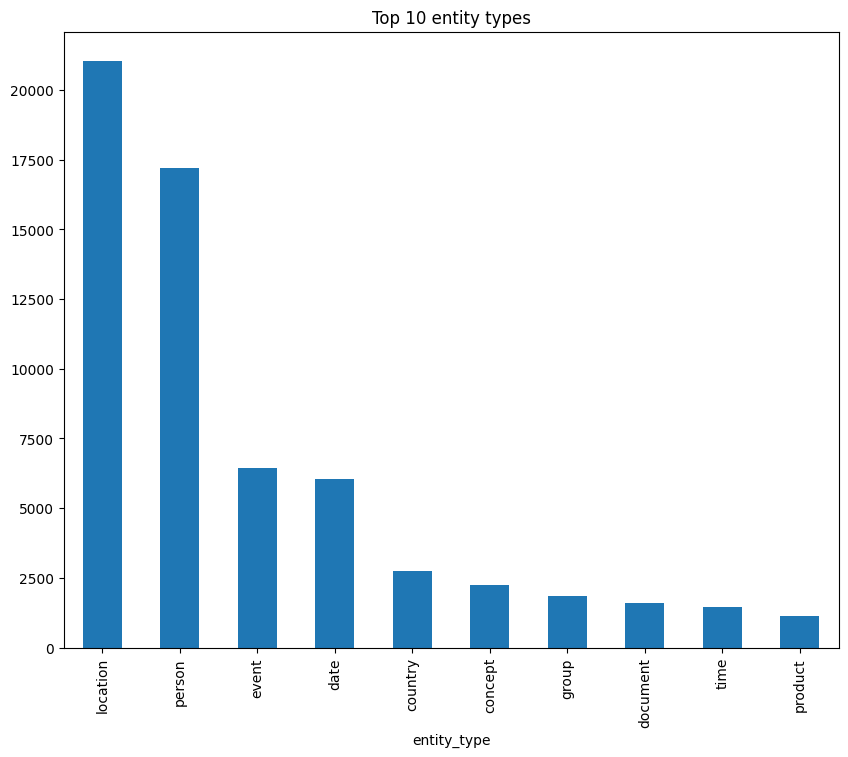

In [80]:
entity_type_counts = df['entity_type'].value_counts()

plt.figure(figsize=(10, 8))
entity_type_counts[:10].plot(kind='bar')
plt.title('Top 10 entity types')

plt.show()

In [88]:
# How many percents does top 1% entity types cover?
top_1_percent = entity_type_counts[:int(len(entity_type_counts) * 0.01)].sum()
percent_covered = top_1_percent / entity_type_counts.sum() * 100
percent_covered

71.66554044672363

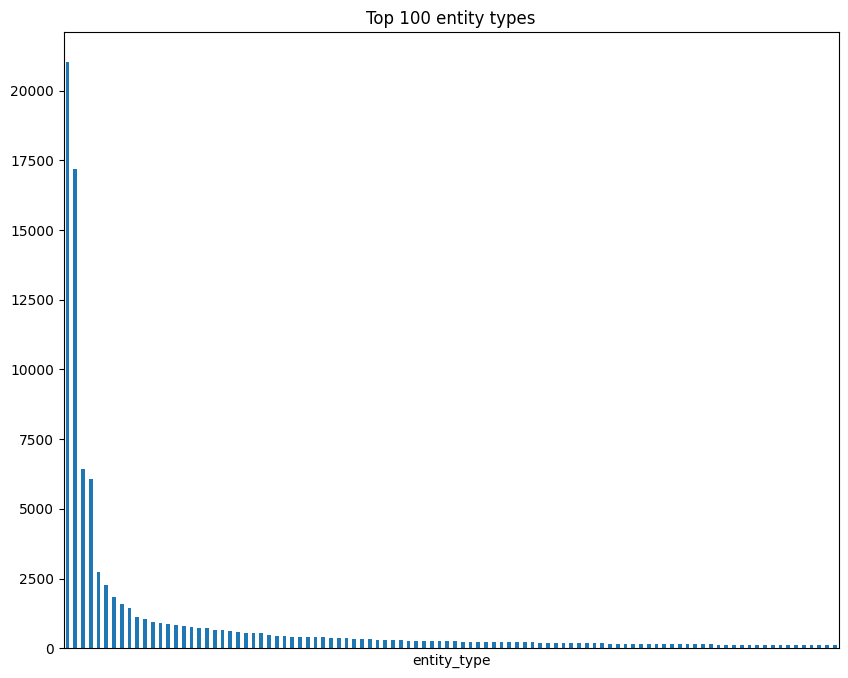

In [84]:
plt.figure(figsize=(10, 8))
entity_type_counts[:100].plot(kind='bar')
plt.title('Top 100 entity types')
plt.xticks([])

plt.show()

# caluclate 1% percentile
entity_type_counts.quantile(0.01)

In [35]:
# convert back to dataset
ner_gen_cleaned = DatasetDict({
    'train': Dataset.from_pandas(df[df['split'] == 'train'], preserve_index=False),
    'test': Dataset.from_pandas(df[df['split'] == 'test'], preserve_index=False),
})
ner_gen_cleaned

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'split', 'label', 'entity_type', 'input_para'],
        num_rows: 116478
    })
    test: Dataset({
        features: ['index', 'text', 'split', 'label', 'entity_type', 'input_para'],
        num_rows: 12772
    })
})

#### Convey the lengths of samples in dataset

Map: 100%|██████████| 12772/12772 [00:01<00:00, 11282.16 examples/s]


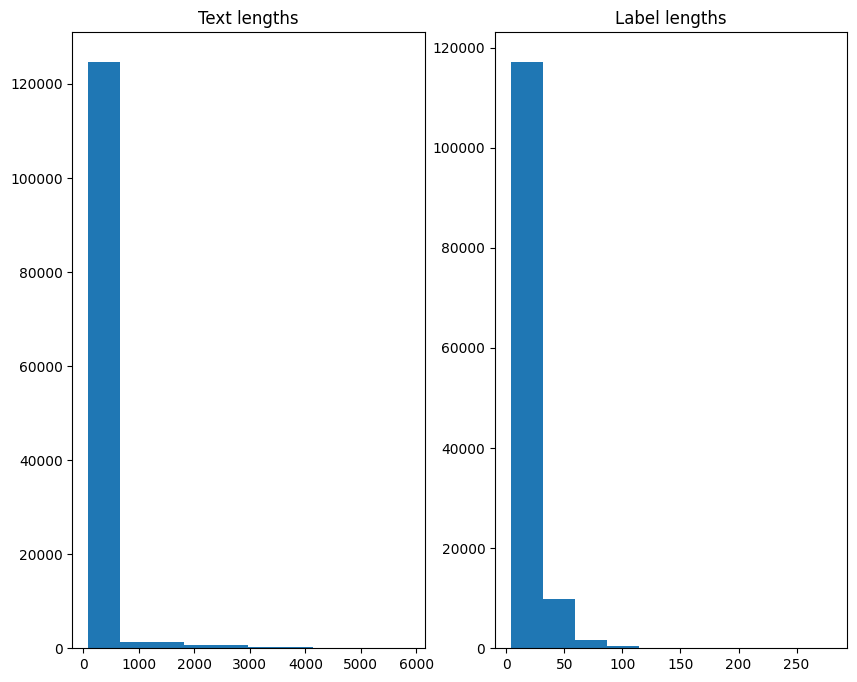

Max text length: 5860
Max label length: 280
Current limit: MAX_LENGTH = 1024


In [36]:
ner_gen_cleaned_with_length = ner_gen_cleaned.map(
    lambda samples: {
        'len_text': [len(x) for x in tokenizer(samples['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
        'len_label': [len(x) for x in tokenizer(samples['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
    },
    batched=True
)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(ner_gen_cleaned_with_length['train']['len_text'] + ner_gen_cleaned_with_length['test']['len_text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(ner_gen_cleaned_with_length['train']['len_label'] + ner_gen_cleaned_with_length['test']['len_label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(ner_gen_cleaned_with_length['train']['len_text'] + ner_gen_cleaned_with_length['test']['len_text']))
print('Max label length:', max(ner_gen_cleaned_with_length['train']['len_label'] + ner_gen_cleaned_with_length['test']['len_label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

Drop those samples that having lengths exceed the pre-defined MAX LENGTH

In [37]:
en_open_ner_cleaned_dropped = ner_gen_cleaned_with_length.filter(
    lambda example: (example['len_text'] <= MAX_LENGTH) and (example['len_label'] <= MAX_LENGTH)
)

Filter: 100%|██████████| 12772/12772 [00:00<00:00, 116320.98 examples/s]


Map: 100%|██████████| 12357/12357 [00:01<00:00, 10615.94 examples/s]


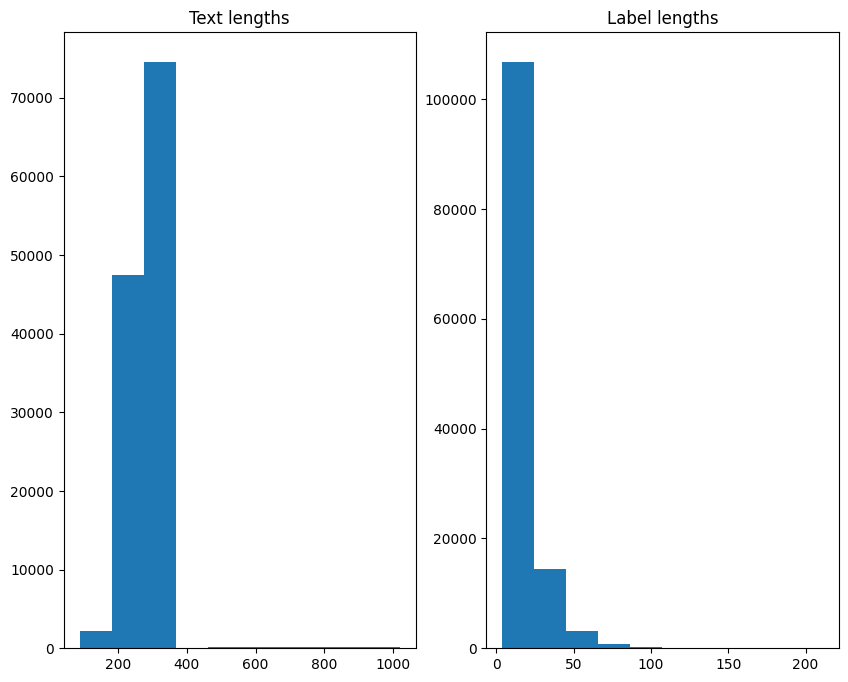

Max text length: 1020
Max label length: 211
Current limit: MAX_LENGTH = 1024


In [38]:
ner_gen_cleaned_with_length_dropped = en_open_ner_cleaned_dropped.map(
    lambda samples: {
        'len_text': [len(x) for x in tokenizer(samples['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
        'len_label': [len(x) for x in tokenizer(samples['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']],
    },
    batched=True
)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(ner_gen_cleaned_with_length_dropped['train']['len_text'] + ner_gen_cleaned_with_length_dropped['test']['len_text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(ner_gen_cleaned_with_length_dropped['train']['len_label'] + ner_gen_cleaned_with_length_dropped['test']['len_label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(ner_gen_cleaned_with_length_dropped['train']['len_text'] + ner_gen_cleaned_with_length_dropped['test']['len_text']))
print('Max label length:', max(ner_gen_cleaned_with_length_dropped['train']['len_label'] + ner_gen_cleaned_with_length_dropped['test']['len_label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

In [39]:
ner_gen_cleaned_with_length_dropped

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'split', 'label', 'entity_type', 'input_para', 'len_text', 'len_label'],
        num_rows: 113161
    })
    test: Dataset({
        features: ['index', 'text', 'split', 'label', 'entity_type', 'input_para', 'len_text', 'len_label'],
        num_rows: 12357
    })
})

In [40]:
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
ner_gen_tokenized = ner_gen_cleaned_with_length_dropped.map(
    lambda x: tokenize(x, tokenizer, "text", "label"),
    batched=True,
    remove_columns=ner_gen_cleaned_with_length_dropped['train'].column_names,
)

print(">> Dataset is ready:")
print(ner_gen_tokenized)

> Tokenizing dataset...


Map:   1%|          | 1000/113161 [00:00<00:12, 9208.94 examples/s]

Map: 100%|██████████| 12357/12357 [00:01<00:00, 8144.31 examples/s]

>> Dataset is ready:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 113161
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12357
    })
})


In [41]:
tokenizer.decode(ner_gen_tokenized['train'][0]['input_ids'])

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: What describes person in the text? ### Input: Dù câu chuyện của các nhân chứng khá chi tiết nhưng các nhà nghiên cứu gặp nhiều khó khăn trong việc tìm kiếm các bằng chứng khoa học để chứng minh linh hồn có thật. Một số chuyên gia cho hay, nếu linh hồn thực sự tồn tại thì sẽ là vật chất hay phi vật chất. Bởi một số trường hợp tuyên bố nhìn thấy hồn ma đi xuyên qua cửa, các bức tường, có thể đóng mở cửa. Theo suy luận logic và các định luật vật lý cơ bản, linh hồn chỉ có thể tồn tại ở một trong 2 loại là vật chất hay phi vật chất ### Response:</s>'

In [47]:
tokenizer.decode(ner_gen_tokenized['train'][20]['labels'])

'["Facebook"]</s>'

In [48]:
output_repo = 'vi-mt5-ner-open_domain'
print(f"> Pushing to hub: {output_repo}")
ner_gen_tokenized.push_to_hub(output_repo)

> Pushing to hub: vi-mt5-ner-open_domain


Creating parquet from Arrow format: 100%|██████████| 114/114 [00:00<00:00, 131.23ba/s]


Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/vi-mt5-ner-open_domain/commit/4732eb24cc0ccda0e247dfbbc57c2bf288357dd1', commit_message='Upload dataset', commit_description='', oid='4732eb24cc0ccda0e247dfbbc57c2bf288357dd1', pr_url=None, pr_revision=None, pr_num=None)

In [49]:
ner_gen_cleaned_with_length_dropped

DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'split', 'label', 'entity_type', 'input_para', 'len_text', 'len_label'],
        num_rows: 113161
    })
    test: Dataset({
        features: ['index', 'text', 'split', 'label', 'entity_type', 'input_para', 'len_text', 'len_label'],
        num_rows: 12357
    })
})

In [50]:
ner_gen_untokenized = ner_gen_cleaned_with_length_dropped.map(
    lambda x: {
        'text': x['input_para'],
        'entity_type': x['entity_type'],
        'label': x['label'],
    },
    remove_columns=ner_gen_cleaned_with_length_dropped['train'].column_names
)
ner_gen_untokenized

Map: 100%|██████████| 12357/12357 [00:00<00:00, 17045.48 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'entity_type'],
        num_rows: 113161
    })
    test: Dataset({
        features: ['text', 'label', 'entity_type'],
        num_rows: 12357
    })
})

In [51]:
output_repo = 'vi-mt5-ner-open_domain-raw'
print(f"> Pushing to hub: {output_repo}")
ner_gen_untokenized.push_to_hub(output_repo)

> Pushing to hub: vi-mt5-ner-open_domain-raw


Creating parquet from Arrow format: 100%|██████████| 114/114 [00:00<00:00, 928.97ba/s]


Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/vi-mt5-ner-open_domain-raw/commit/b44213217adbb5bdac50317eccd0254eb71651ef', commit_message='Upload dataset', commit_description='', oid='b44213217adbb5bdac50317eccd0254eb71651ef', pr_url=None, pr_revision=None, pr_num=None)

### 3. Dataset VLSP 2021 - *GOLD* data & Eval data

In [4]:
# output repo in huggingface
output_repo = 'vi-mT5-ner-vlsp-GOLD'
eval_repo = 'eval-vi-ner-vlsp-GOLD'

In [5]:
data_dirs = [
    'datasets/NER_VLSP_2021/NER-Data-Muc',
    'datasets/NER_VLSP_2021/Data-Muc-Addition'
]
data_paths = [path for data_dir in data_dirs for path in glob.glob(data_dir+'/*')]
len(data_paths)

1500

In [6]:
# dev paths are path that start with "0_dev"
# test paths are path that start with "1_test"
# train paths are the rest
dev_paths = [path for path in data_paths if path.split('/')[-1].startswith('0_dev')]
test_paths = [path for path in data_paths if path.split('/')[-1].startswith('1_test')]
train_paths = [path for path in data_paths if (path not in dev_paths) and (path not in test_paths)]

len(train_paths), len(dev_paths), len(test_paths)

(1050, 210, 240)

In [7]:
vi_vlsp_ner = DatasetDict({
    'train': Dataset.from_dict({'file_path': train_paths, 'split': ['train']*len(train_paths)}),
    'dev': Dataset.from_dict({'file_path': dev_paths, 'split': ['dev']*len(dev_paths)}),
    'test': Dataset.from_dict({'file_path': test_paths, 'split': ['test']*len(test_paths)}),
})
vi_vlsp_ner

DatasetDict({
    train: Dataset({
        features: ['file_path', 'split'],
        num_rows: 1050
    })
    dev: Dataset({
        features: ['file_path', 'split'],
        num_rows: 210
    })
    test: Dataset({
        features: ['file_path', 'split'],
        num_rows: 240
    })
})

In [8]:
def parse_muc_data(text):
    # parse each sample NER data text into a dictionary:
    # key "text": The text after remove all labels
    # key "entities": a list of tuples, each tuple contains the entity type and the entity text
    samples = defaultdict(list)
    
    for line in text.split('\n'):
        if not line:
            continue        
        
        # extract entities
        entities = re.findall(r'<ENAMEX TYPE="([^"]*)">([^<]*)</ENAMEX>', line)
        # remove all labels to get the text
        line = re.sub(r'<ENAMEX[^>]*>', '', line)
        line = re.sub(r'</ENAMEX>', '', line)

        entity_dict = defaultdict(list)
        for entity_type, entity_text in set(entities):
            entity_dict[entity_type].append(entity_text)

        for entity_type, entity_texts in entity_dict.items():
            samples['input_para'].append(line)
            samples['entity_type'].append(entity_type)
            samples['label'].append(entity_texts)

    return samples

def read_muc_files(file_paths, splits):
    # read all MUC files and parse them
    samples = defaultdict(list)
    for file_path, split in zip(file_paths, splits):
        with open(file_path, 'r') as f:
            text = f.read()
            samples_in_text = parse_muc_data(text)
            samples['input_para'].extend(samples_in_text['input_para'])
            samples['entity_type'].extend(samples_in_text['entity_type'])
            samples['label'].extend(samples_in_text['label'])
            samples['split'].extend([split]*len(samples_in_text['input_para']))
            
    return samples

vi_vlsp_ner_parsed = vi_vlsp_ner.map(
    lambda x: read_muc_files(x['file_path'], x['split']),
    batched=True,
    remove_columns=['file_path']
)
vi_vlsp_ner_parsed

Map: 100%|██████████| 240/240 [00:00<00:00, 4287.63 examples/s]


DatasetDict({
    train: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 25970
    })
    dev: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 4373
    })
    test: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 8619
    })
})

In [9]:
# ref: https://learn.microsoft.com/en-in/azure/ai-services/language-service/named-entity-recognition/concepts/named-entity-categories?tabs=ga-api#category-location

# entity_types_to_drop = ['*', 'MISCELLANEOUS']
entity_type_map = {
    'ADDRESS': ['address'],
    'DATETIME': ['datetime'],
    'DATETIME-DATE': ['date', 'calendar date', 'datetime-date'],
    'DATETIME-DATERANGE': ['date range', 'datetime-daterange'],
    'DATETIME-DURATION': ['duration', 'datetime-duration'],
    'DATETIME-SET': ['set', 'repeated time', 'datetime-set'],
    'DATETIME-TIME': ['time', 'time of day', 'datetime-time'],
    'DATETIME-TIMERANGE': ['time range', 'datetime-timerange'],
    'EMAIL': ['email'],
    'EVENT': ['event'],
    'EVENT-CUL': ['cultural event', 'holiday', 'event-cul'],
    'EVENT-GAMESHOW': ['game show', 'event-gameshow'],
    'EVENT-NATURAL': ['natural event', 'event-natural'],
    'EVENT-SPORT': ['sport event', 'event-sport'],
    'IP': ['ip'],
    'LOCATION': ['location'],
    'LOCATION-GEO': ['geographical location', 'location-geo'],
    'LOCATION-GPE': ['geopolitical entity', 'location-gpe'],
    'LOCATION-STRUC': ['manmade structure', 'location-struc'],
    'ORGANIZATION': ['organization'],
    'ORGANIZATION-MED': ['medical organization', 'organization-med'],
    'ORGANIZATION-SPORTS': ['sport-related organization', 'organization-sports'],
    'ORGANIZATION-STOCK': ['stock organization', 'organization-stock'],
    'PERSON': ['person'],
    'PERSONTYPE': ['person role', 'persontype'],
    'PHONENUMBER': ['phone number', 'phonenumber'],
    'PRODUCT': ['product'],
    'PRODUCT-AWARD': ['award', 'product-award'],
    'PRODUCT-COM': ['product-com'],
    'PRODUCT-LEGAL': ['legal', 'product-legal'],
    'QUANTITY': ['quantity'],
    'QUANTITY-AGE': ['age', 'quantity-age'],
    'QUANTITY-CUR': ['currency', 'quantity-cur'],
    'QUANTITY-DIM': ['dimension', 'measurements', 'quantity-dim'],
    'QUANTITY-NUM': ['number', 'quantity-num'],
    'QUANTITY-ORD': ['ordinal number', 'quantity-ord'],
    'QUANTITY-PER': ['percentage', 'quantity-per'],
    'QUANTITY-TEM': ['temperature', 'quantity-tem'],
    'SKILL': ['skill'],
    'URL': ['url'],
}

def update_entity_type(samples):
    new_samples = defaultdict(list)
    for input_para, label, entity_type, split in zip(samples['input_para'], samples['label'], samples['entity_type'], samples['split']):
        if entity_type in entity_type_map:
            new_samples['input_para'].append(input_para)
            new_samples['label'].append(label)
            new_samples['entity_type'].append(
                random.choice(entity_type_map[entity_type])
            )
            new_samples['split'].append(split)

    return new_samples

vi_vlsp_ner_renamed = vi_vlsp_ner_parsed.map(
    lambda x: update_entity_type(x),
    batched=True

)
vi_vlsp_ner_renamed

Map: 100%|██████████| 8619/8619 [00:00<00:00, 130965.64 examples/s]


DatasetDict({
    train: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 25587
    })
    dev: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 4304
    })
    test: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label'],
        num_rows: 8543
    })
})

In [10]:
# turn into dataframe
df = pd.concat([
        vi_vlsp_ner_renamed['train'].to_pandas(), 
        vi_vlsp_ner_renamed['dev'].to_pandas(), 
        vi_vlsp_ner_renamed['test'].to_pandas()
    ], 
    ignore_index=True)
df

,split,input_para,entity_type,label
0,train,Mỹ chấp thuận hàng loạt biện pháp trừng phạt m...,geopolitical entity,"[Triều Tiên, Mỹ]"
1,train,"Bộ Tài chính Mỹ sẽ loại bỏ bất kỳ cá nhân, tổ ...",location-gpe,"[Triều Tiên, Mỹ]"
2,train,Ảnh: Bloomberg,organization,[Bloomberg]
3,train,"Trong ngày thứ Ba, Tổng thống Donald Trump đã ...",person,[Donald Trump]
4,train,"Trong ngày thứ Ba, Tổng thống Donald Trump đã ...",persontype,[Tổng thống]
...,...,...,...,...
38429,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",quantity,[137cm]
38430,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",person,"[Allegra Cole, Allegra]"
38431,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",persontype,"[người mẫu, giáo viên]"
38432,test,Theo Khánh Hằng (Theo Mirror) (Khám Phá),person,[Khánh Hằng]


In [11]:
print(type(df.loc[0, 'label']))
df['label'] = df['label'].map(lambda x: x.tolist())
print(type(df.loc[0, 'label']))

<class 'numpy.ndarray'>
<class 'list'>


In [12]:
# create instruction prompt
df['prompt'] = df.apply(
    lambda x: prompt_input({
        'instruction': ner_instruction(x['entity_type']),
        'input': x['input_para'],
    }),
    axis=1
)
df

,split,input_para,entity_type,label,prompt
0,train,Mỹ chấp thuận hàng loạt biện pháp trừng phạt m...,geopolitical entity,"[Triều Tiên, Mỹ]","Below is an instruction that describes a task,..."
1,train,"Bộ Tài chính Mỹ sẽ loại bỏ bất kỳ cá nhân, tổ ...",location-gpe,"[Triều Tiên, Mỹ]","Below is an instruction that describes a task,..."
2,train,Ảnh: Bloomberg,organization,[Bloomberg],"Below is an instruction that describes a task,..."
3,train,"Trong ngày thứ Ba, Tổng thống Donald Trump đã ...",person,[Donald Trump],"Below is an instruction that describes a task,..."
4,train,"Trong ngày thứ Ba, Tổng thống Donald Trump đã ...",persontype,[Tổng thống],"Below is an instruction that describes a task,..."
...,...,...,...,...,...
38429,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",quantity,[137cm],"Below is an instruction that describes a task,..."
38430,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",person,"[Allegra Cole, Allegra]","Below is an instruction that describes a task,..."
38431,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",persontype,"[người mẫu, giáo viên]","Below is an instruction that describes a task,..."
38432,test,Theo Khánh Hằng (Theo Mirror) (Khám Phá),person,[Khánh Hằng],"Below is an instruction that describes a task,..."


In [13]:
# map label to string
df['label'] = df['label'].map(lambda lst: f'''[{', '.join(f"""\"{ele.replace("\'", "\\'").replace('\"', '\\"')}\"""" for ele in lst)}]''')
df

,split,input_para,entity_type,label,prompt
0,train,Mỹ chấp thuận hàng loạt biện pháp trừng phạt m...,geopolitical entity,"[""Triều Tiên"", ""Mỹ""]","Below is an instruction that describes a task,..."
1,train,"Bộ Tài chính Mỹ sẽ loại bỏ bất kỳ cá nhân, tổ ...",location-gpe,"[""Triều Tiên"", ""Mỹ""]","Below is an instruction that describes a task,..."
2,train,Ảnh: Bloomberg,organization,"[""Bloomberg""]","Below is an instruction that describes a task,..."
3,train,"Trong ngày thứ Ba, Tổng thống Donald Trump đã ...",person,"[""Donald Trump""]","Below is an instruction that describes a task,..."
4,train,"Trong ngày thứ Ba, Tổng thống Donald Trump đã ...",persontype,"[""Tổng thống""]","Below is an instruction that describes a task,..."
...,...,...,...,...,...
38429,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",quantity,"[""137cm""]","Below is an instruction that describes a task,..."
38430,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",person,"[""Allegra Cole"", ""Allegra""]","Below is an instruction that describes a task,..."
38431,test,"Allegra Cole có vòng một lên đến 137cm, lớn đế...",persontype,"[""người mẫu"", ""giáo viên""]","Below is an instruction that describes a task,..."
38432,test,Theo Khánh Hằng (Theo Mirror) (Khám Phá),person,"[""Khánh Hằng""]","Below is an instruction that describes a task,..."


In [14]:
df.iloc[0]['prompt']

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction: What describes geopolitical entity in the text?\n\n### Input: Mỹ chấp thuận hàng loạt biện pháp trừng phạt mới chống Triều Tiên\n\n### Response:\n'

In [15]:
df.iloc[0]['label']

'["Triều Tiên", "Mỹ"]'

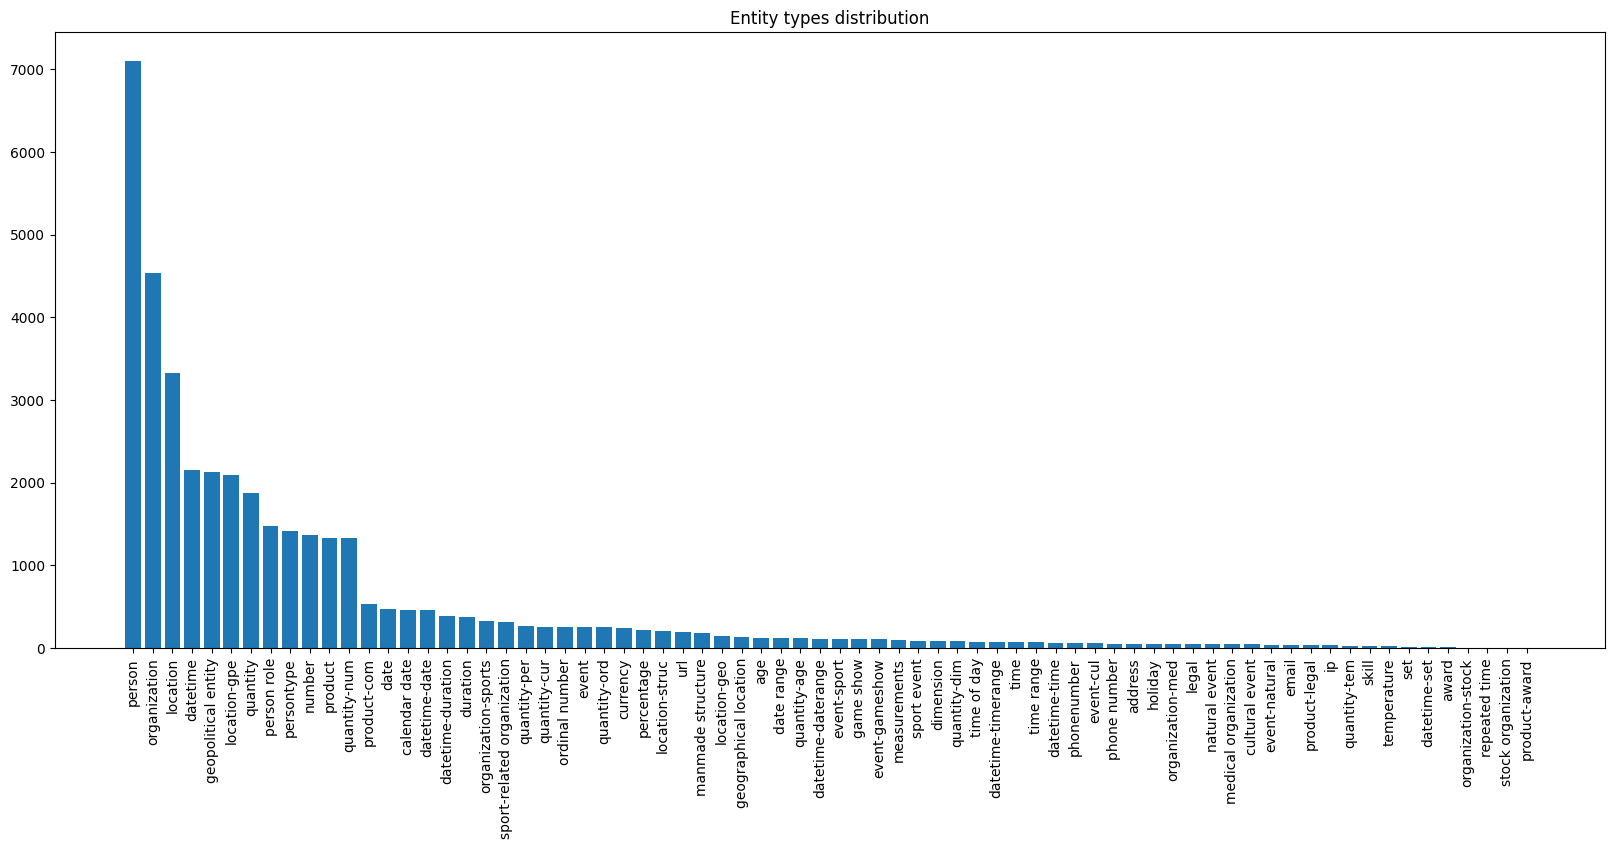

In [16]:
entity_types_count = df['entity_type'].value_counts()

# plot bar chart
plt.figure(figsize=(20, 8))
plt.bar(entity_types_count.index, entity_types_count.values)
plt.xticks(rotation=90)
plt.title('Entity types distribution')
plt.show()


In [17]:
df['len_text'] = df['input_para'].apply(lambda x: len(tokenizer(x)['input_ids']))
df['len_label'] = df['label'].apply(lambda x: len(tokenizer(str(x))['input_ids']))
df['len_prompt'] = df['prompt'].apply(lambda x: len(tokenizer(x)['input_ids']))
df.describe()

,len_text,len_label,len_prompt
count,38434.000000,38434.000000,38434.000000
mean,129.044180,9.776110,192.047042
std,93.469521,8.658625,93.493583
min,2.000000,3.000000,64.000000
25%,73.000000,5.000000,137.000000
50%,115.000000,7.000000,178.000000
75%,163.000000,11.000000,226.000000
max,1799.000000,416.000000,1864.000000


In [18]:
# Only take samples with text length < 512
df = df[df['len_text'] < 512]
df.describe()

,len_text,len_label,len_prompt
count,38250.000000,38250.000000,38250.000000
mean,125.899608,9.699948,188.902641
std,78.020236,7.650872,78.051353
min,2.000000,3.000000,64.000000
25%,73.000000,5.000000,136.000000
50%,114.000000,7.000000,177.000000
75%,162.000000,11.000000,225.000000
max,510.000000,238.000000,573.000000


In [19]:
# convert to dataset
vi_vlsp_ner_cleaned = DatasetDict({
    'train': Dataset.from_pandas(df[df['split'] == 'train'], preserve_index=False),
    'eval': Dataset.from_pandas(df[df['split'] == 'dev'], preserve_index=False),
})
vi_vlsp_ner_cleaned

DatasetDict({
    train: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label', 'prompt', 'len_text', 'len_label', 'len_prompt'],
        num_rows: 25495
    })
    eval: Dataset({
        features: ['split', 'input_para', 'entity_type', 'label', 'prompt', 'len_text', 'len_label', 'len_prompt'],
        num_rows: 4265
    })
})

In [20]:
# rename column in df
eval_df = df[df['split'] == 'test'].rename(columns={'input_para': 'text'})[['text', 'entity_type', 'label']]

# convert to dataset
eval_vi_vlsp_ner_cleaned = DatasetDict({
    'test': Dataset.from_pandas(eval_df, preserve_index=False),
})
eval_vi_vlsp_ner_cleaned

DatasetDict({
    test: Dataset({
        features: ['text', 'entity_type', 'label'],
        num_rows: 8490
    })
})

In [21]:
# Tokenize
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
vi_vlsp_ner_tokenized = vi_vlsp_ner_cleaned.map(
    lambda x: tokenize(x, tokenizer, "prompt", "label"),
    batched=True,
    remove_columns=vi_vlsp_ner_cleaned['train'].column_names,
)
vi_vlsp_ner_tokenized

> Tokenizing dataset...


Map: 100%|██████████| 4265/4265 [00:00<00:00, 8798.43 examples/s] 


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 25495
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4265
    })
})

In [22]:
tokenizer.decode(vi_vlsp_ner_tokenized['train'][10]['input_ids'])

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: What describes person in the text? ### Input: Cũng theo Tổng thống Donald Trump, chính phủ Trung Quốc đang yêu cầu tất cả các tổ chức tài chính nước này ngừng giao dịch với chính quyền Kim Jong Un. Đây có thể coi như quyết sách vô cùng quan trọng của đất nước hiện đang giữ vị thế đối tác thương mại lớn nhất của Triều Tiên. ### Response:</s>'

In [23]:
tokenizer.decode(vi_vlsp_ner_tokenized['train'][10]['labels'])

'["Kim Jong Un", "Donald Trump"]</s>'

In [24]:
eval_vi_vlsp_ner_cleaned['test'][200]

{'text': 'CTD: CTCP Xây dựng Coteccons (MCK: CTD) công bố báo cáo kết quả phát hành cổ phiếu theo chương trình lựa chọn cho người lao động trong công ty. Theo đó, <CTD đã phân phối 1.305.000 cổ phiếu tới người lao động, với mệnh giá mỗi cổ phiếu là 40.000 đồng/cổ phiếu.',
 'entity_type': 'organization',
 'label': '["CTCP Xây dựng Coteccons", "CTD"]'}

In [25]:
print(f"> Pushing to hub: {output_repo}")
vi_vlsp_ner_tokenized.push_to_hub(output_repo)

> Pushing to hub: vi-mT5-ner-vlsp-GOLD


Creating parquet from Arrow format: 100%|██████████| 26/26 [00:00<00:00, 173.81ba/s]


Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/vi-mT5-ner-vlsp-GOLD/commit/dc934cd5a84933ff73be436e3448125c35206cbc', commit_message='Upload dataset', commit_description='', oid='dc934cd5a84933ff73be436e3448125c35206cbc', pr_url=None, pr_revision=None, pr_num=None)

In [26]:
print(f"> Pushing to hub: {eval_repo}")
eval_vi_vlsp_ner_cleaned.push_to_hub(eval_repo)

> Pushing to hub: eval-vi-ner-vlsp-GOLD


Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/eval-vi-ner-vlsp-GOLD/commit/5393f27b512a6f7c44853ac7ec4b8f23d64fe8d1', commit_message='Upload dataset', commit_description='', oid='5393f27b512a6f7c44853ac7ec4b8f23d64fe8d1', pr_url=None, pr_revision=None, pr_num=None)

### 4. VinAI - Vietnamese COVID-19 NER

In [22]:
output_repo = 'vi-mT5-ner-VinAI-COVID_19_NER'
eval_repo = 'eval-vi-ner-VinAI-COVID_19_NER'

In [23]:
vi_ner_vinai_train = load_dataset('json', data_files='datasets/PhoNER_COVID19/data/syllable/train_syllable.json')['train']
vi_ner_vinai_dev = load_dataset('json', data_files='datasets/PhoNER_COVID19/data/syllable/dev_syllable.json')['train']
vi_ner_vinai_test = load_dataset('json', data_files='datasets/PhoNER_COVID19/data/syllable/test_syllable.json')['train']

vi_ner_vinai = DatasetDict({
    'train': vi_ner_vinai_train.map(lambda x: {'split': 'train'}),
    'dev': vi_ner_vinai_dev.map(lambda x: {'split': 'dev'}),
    'test': vi_ner_vinai_test.map(lambda x: {'split': 'test'}),
})
vi_ner_vinai

DatasetDict({
    train: Dataset({
        features: ['words', 'tags', 'split'],
        num_rows: 5027
    })
    dev: Dataset({
        features: ['words', 'tags', 'split'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['words', 'tags', 'split'],
        num_rows: 3000
    })
})

In [24]:
all_tags = set([
    tag for tags in vi_ner_vinai['train']['tags'] + vi_ner_vinai['dev']['tags'] + vi_ner_vinai['test']['tags']
    for tag in tags
])
all_entity_types = set([
    tag.split('-')[1].lower() for tag in all_tags if tag != 'O'
])

all_entity_types

{'age',
 'date',
 'gender',
 'job',
 'location',
 'name',
 'organization',
 'patient_id',
 'symptom_and_disease',
 'transportation'}

In [25]:
vi_ner_vinai

DatasetDict({
    train: Dataset({
        features: ['words', 'tags', 'split'],
        num_rows: 5027
    })
    dev: Dataset({
        features: ['words', 'tags', 'split'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['words', 'tags', 'split'],
        num_rows: 3000
    })
})

In [26]:
def parse_tags_data(words, tags):
    samples = defaultdict(list)
    
    for sample_words, sample_tags in zip(words, tags):
        entities = defaultdict(list)

        full_text = ' '.join(sample_words)
        cur_entity_text = []
        cur_entity_type = ''
        
        for word, tag in zip(sample_words, sample_tags):
            if tag != 'O':
                entity_pos, entity_type = tag.lower().split('-')
                if entity_pos == 'b':
                    if cur_entity_text:
                        entities[cur_entity_type].append(' '.join(cur_entity_text))
                        cur_entity_text = []
                    cur_entity_type = entity_type
                cur_entity_text.append(word)
            else:
                if cur_entity_text:
                    entities[cur_entity_type].append(' '.join(cur_entity_text))
                    cur_entity_text = []

        if cur_entity_text:
            entities[cur_entity_type].append(' '.join(cur_entity_text))
            
        samples['input_para'].extend([full_text] * len(entities))
        samples['entity_type'].extend(list(entities.keys()))
        samples['label'].extend(list(entities.values()))

    return samples

vi_ner_vinai_parsed = vi_ner_vinai.map(
    lambda x: parse_tags_data(x['words'], x['tags']),
    batched=True,
    remove_columns=vi_ner_vinai['train'].column_names
)
vi_ner_vinai_parsed


DatasetDict({
    train: Dataset({
        features: ['input_para', 'entity_type', 'label'],
        num_rows: 10335
    })
    dev: Dataset({
        features: ['input_para', 'entity_type', 'label'],
        num_rows: 4576
    })
    test: Dataset({
        features: ['input_para', 'entity_type', 'label'],
        num_rows: 7075
    })
})

In [27]:
df = concatenate_datasets([
    vi_ner_vinai_parsed["train"].map(lambda x: {'split': 'train', **x}),
    vi_ner_vinai_parsed["dev"].map(lambda x: {'split': 'dev', **x}),
    vi_ner_vinai_parsed["test"].map(lambda x: {'split': 'test', **x}),
]).to_pandas()
df

,input_para,entity_type,label,split
0,"Đồng thời , bệnh viện tiếp tục thực hiện các b...",organization,[Bộ Y tế],train
1,""" Số bệnh viện có thể tiếp nhận bệnh nhân bị s...",symptom_and_disease,"[sốt cao, khó thở]",train
2,"Bà này khi trở về quá cảnh Doha ( Qatar ) , đá...",location,"[Doha, Qatar, Tân Sơn Nhất]",train
3,"Bà này khi trở về quá cảnh Doha ( Qatar ) , đá...",date,[2/3],train
4,""" Bệnh nhân 523 "" và chồng là "" bệnh nhân 522 ...",patient_id,"[523, 522]",train
...,...,...,...,...
21981,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",date,[20 - 2],test
21982,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",location,"[Vĩnh Phúc, Bệnh viện Nhi trung ương]",test
21983,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",name,[N.G.L.],test
21984,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",age,[3 tháng],test


In [28]:
df['entity_type'] = df['entity_type'].map(lambda x: x.replace('_', ' '))

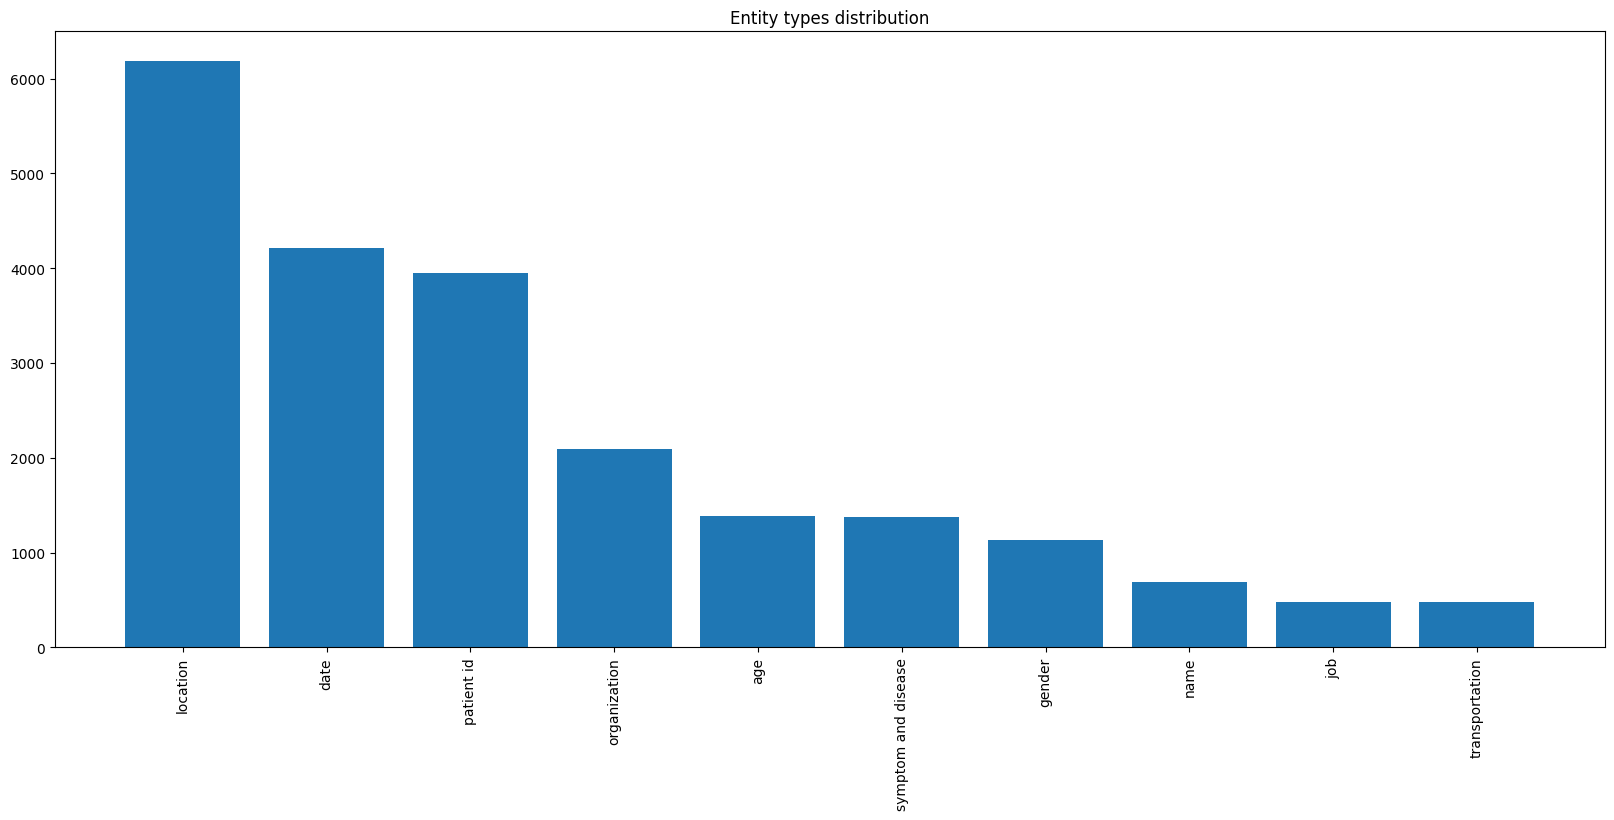

In [29]:
entity_types_count = df['entity_type'].value_counts()

# plot bar chart
plt.figure(figsize=(20, 8))
plt.bar(entity_types_count.index, entity_types_count.values)
plt.xticks(rotation=90)
plt.title('Entity types distribution')
plt.show()


In [30]:
# create instruction prompt
df['prompt'] = df.apply(
    lambda x: prompt_input({
        'instruction': ner_instruction(x['entity_type']),
        'input': x['input_para'],
    }),
    axis=1
)
df

,input_para,entity_type,label,split,prompt
0,"Đồng thời , bệnh viện tiếp tục thực hiện các b...",organization,[Bộ Y tế],train,"Below is an instruction that describes a task,..."
1,""" Số bệnh viện có thể tiếp nhận bệnh nhân bị s...",symptom and disease,"[sốt cao, khó thở]",train,"Below is an instruction that describes a task,..."
2,"Bà này khi trở về quá cảnh Doha ( Qatar ) , đá...",location,"[Doha, Qatar, Tân Sơn Nhất]",train,"Below is an instruction that describes a task,..."
3,"Bà này khi trở về quá cảnh Doha ( Qatar ) , đá...",date,[2/3],train,"Below is an instruction that describes a task,..."
4,""" Bệnh nhân 523 "" và chồng là "" bệnh nhân 522 ...",patient id,"[523, 522]",train,"Below is an instruction that describes a task,..."
...,...,...,...,...,...
21981,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",date,[20 - 2],test,"Below is an instruction that describes a task,..."
21982,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",location,"[Vĩnh Phúc, Bệnh viện Nhi trung ương]",test,"Below is an instruction that describes a task,..."
21983,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",name,[N.G.L.],test,"Below is an instruction that describes a task,..."
21984,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",age,[3 tháng],test,"Below is an instruction that describes a task,..."


In [31]:
# map label to string
df['label'] = df['label'].map(lambda lst: f'''[{', '.join(f"""\"{ele.replace("\'", "\\'").replace('\"', '\\"')}\"""" for ele in lst)}]''')
df

,input_para,entity_type,label,split,prompt
0,"Đồng thời , bệnh viện tiếp tục thực hiện các b...",organization,"[""Bộ Y tế""]",train,"Below is an instruction that describes a task,..."
1,""" Số bệnh viện có thể tiếp nhận bệnh nhân bị s...",symptom and disease,"[""sốt cao"", ""khó thở""]",train,"Below is an instruction that describes a task,..."
2,"Bà này khi trở về quá cảnh Doha ( Qatar ) , đá...",location,"[""Doha"", ""Qatar"", ""Tân Sơn Nhất""]",train,"Below is an instruction that describes a task,..."
3,"Bà này khi trở về quá cảnh Doha ( Qatar ) , đá...",date,"[""2/3""]",train,"Below is an instruction that describes a task,..."
4,""" Bệnh nhân 523 "" và chồng là "" bệnh nhân 522 ...",patient id,"[""523"", ""522""]",train,"Below is an instruction that describes a task,..."
...,...,...,...,...,...
21981,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",date,"[""20 - 2""]",test,"Below is an instruction that describes a task,..."
21982,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",location,"[""Vĩnh Phúc"", ""Bệnh viện Nhi trung ương""]",test,"Below is an instruction that describes a task,..."
21983,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",name,"[""N.G.L.""]",test,"Below is an instruction that describes a task,..."
21984,"Ngày 20 - 2 , cùng lúc có 3 bệnh nhân ở Vĩnh P...",age,"[""3 tháng""]",test,"Below is an instruction that describes a task,..."


In [32]:
# for each entity type, only select randomly n samples of that type
# n in (100, 500, 1k, 10k, full)
df_train_100 = df[df['split'] == 'train'].groupby('entity_type').apply(lambda x: x.sample(10, replace=False)).reset_index(drop=True)
df_train_500 = df[df['split'] == 'train'].groupby('entity_type').apply(lambda x: x.sample(50, replace=False)).reset_index(drop=True)
df_train_1k = df[df['split'] == 'train'].groupby('entity_type').apply(lambda x: x.sample(100, replace=False)).reset_index(drop=True)
df_train_5k = df[df['split'] == 'train'].groupby('entity_type').apply(lambda x: x.sample(500, replace=True)).reset_index(drop=True)
df_train_full = df[df['split'] == 'train']
df_dev = df[df['split'] == 'dev']
df_test = df[df['split'] == 'test']

/tmp/ipykernel_3664546/1782800079.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_100 = df[df['split'] == 'train'].groupby('entity_type').apply(lambda x: x.sample(10, replace=False)).reset_index(drop=True)
/tmp/ipykernel_3664546/1782800079.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_500 = df[df['split'] == 'train'].groupby('entity_type').apply(lambda x: x.sample(50, replace=Fal

In [33]:
vi_ner_vinai_processed_train = DatasetDict({
    'train_100': Dataset.from_pandas(df_train_100, preserve_index=False),
    'train_500': Dataset.from_pandas(df_train_500, preserve_index=False),
    'train_1k': Dataset.from_pandas(df_train_1k, preserve_index=False),
    'train_5k': Dataset.from_pandas(df_train_5k, preserve_index=False),
    'train_full': Dataset.from_pandas(df_train_full, preserve_index=False),
    'val': Dataset.from_pandas(df_dev, preserve_index=False)
})

vi_ner_vinai_processed_test = DatasetDict({
    'test': Dataset.from_pandas(
        df_test[['input_para', 'entity_type', 'label']].rename(columns={'input_para': 'text'}), 
        preserve_index=False
    )
})

vi_ner_vinai_processed_train, vi_ner_vinai_processed_test

(DatasetDict({
     train_100: Dataset({
         features: ['input_para', 'entity_type', 'label', 'split', 'prompt'],
         num_rows: 100
     })
     train_500: Dataset({
         features: ['input_para', 'entity_type', 'label', 'split', 'prompt'],
         num_rows: 500
     })
     train_1k: Dataset({
         features: ['input_para', 'entity_type', 'label', 'split', 'prompt'],
         num_rows: 1000
     })
     train_5k: Dataset({
         features: ['input_para', 'entity_type', 'label', 'split', 'prompt'],
         num_rows: 5000
     })
     train_full: Dataset({
         features: ['input_para', 'entity_type', 'label', 'split', 'prompt'],
         num_rows: 10335
     })
     val: Dataset({
         features: ['input_para', 'entity_type', 'label', 'split', 'prompt'],
         num_rows: 4576
     })
 }),
 DatasetDict({
     test: Dataset({
         features: ['text', 'entity_type', 'label'],
         num_rows: 7075
     })
 }))

In [34]:
# Tokenize
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
vi_ner_vinai_tokenized = vi_ner_vinai_processed_train.map(
    lambda x: tokenize(x, tokenizer, "prompt", "label"),
    batched=True,
    remove_columns=vi_ner_vinai_processed_train['train_full'].column_names,
)
vi_ner_vinai_tokenized

> Tokenizing dataset...


Map:  40%|████      | 2000/5000 [00:00<00:00, 17575.94 examples/s]

Map: 100%|██████████| 4576/4576 [00:00<00:00, 16058.37 examples/s]


DatasetDict({
    train_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    train_500: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    train_1k: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    train_5k: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    train_full: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10335
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4576
    })
})

In [35]:
tokenizer.decode(vi_ner_vinai_tokenized['train_full'][10]['input_ids'])

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: What describes date in the text? ### Input: Trường hợp bệnh nhân 188 L.T.H., theo thông tin từ cơ quan y tế địa phương, bệnh nhân về nhà ngày 14 - 4 và từ đó chỉ tiếp xúc với chồng và con, đây không phải là tái nhiễm mà do có thể virus yếu ở thời điểm lấy mẫu lần trước, hoặc vị trí lấy mẫu, thời điểm lấy mẫu dẫn đến âm tính giả. ### Response:</s>'

In [36]:
tokenizer.decode(vi_ner_vinai_tokenized['train_full'][10]['labels'])

'["14 - 4"]</s>'

In [37]:
vi_ner_vinai_processed_test['test'][450]

{'text': 'Hai ngày sau , anh bắt đầu ho dữ dội , có đờm đỏ .',
 'entity_type': 'symptom and disease',
 'label': '["ho dữ dội", "có đờm đỏ"]'}

In [38]:
print(f"> Pushing to hub: {output_repo}")
vi_ner_vinai_tokenized.push_to_hub(output_repo)

> Pushing to hub: vi-mT5-ner-VinAI-COVID_19_NER


Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 686.58ba/s]


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/vi-mT5-ner-VinAI-COVID_19_NER/commit/a6f8ebde815d94aaa081a06ca3dfd88b1cc32128', commit_message='Upload dataset', commit_description='', oid='a6f8ebde815d94aaa081a06ca3dfd88b1cc32128', pr_url=None, pr_revision=None, pr_num=None)

In [39]:
print(f"> Pushing to hub: {eval_repo}")
vi_ner_vinai_processed_test.push_to_hub(eval_repo)

> Pushing to hub: eval-vi-ner-VinAI-COVID_19_NER


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/eval-vi-ner-VinAI-COVID_19_NER/commit/850345adc401e0f881c9817b10d86ca56b60aa01', commit_message='Upload dataset', commit_description='', oid='850345adc401e0f881c9817b10d86ca56b60aa01', pr_url=None, pr_revision=None, pr_num=None)

### 5. UNER_English-EWT eval dataset

In [ ]:
# Cloned from: https://github.com/UniversalNER/UNER_English-EWT.git

In [74]:
from collections import defaultdict

def read_and_process_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = defaultdict(list)
    cur_text = ''
    cur_entities = defaultdict(list)
    cur_entity_type = ''
    cur_entity_text = ''
    
    for line in lines:
        line = line.strip()

        if line.startswith('# text = '):
            cur_text = line.split(' = ', 1)[1]
        elif line and not line.startswith('#'):
            parts = line.split('\t')
            token, tag = parts[1], parts[2]
            if tag != 'O':
                entity_type = tag.split('-')[-1]
                if entity_type == cur_entity_type:
                    cur_entity_text += ' ' + token
                else:
                    if cur_entity_type:
                        cur_entities[cur_entity_type].append(cur_entity_text)
                    cur_entity_type = entity_type
                    cur_entity_text = token
            else:
                if cur_entity_type:
                    cur_entities[cur_entity_type].append(cur_entity_text)
                    cur_entity_type = ''
                    cur_entity_text = ''
        elif not line and cur_text:
            for entity_type, entity_texts in cur_entities.items():
                data['text'].append(cur_text)
                data['entity_type'].append(entity_type)
                data['label'].append(entity_texts)
            cur_text = ''
            cur_entities = defaultdict(list)
            cur_entity_type = ''
            cur_entity_text = ''

    return dict(data)

# Usage example
file_path = 'datasets/uner/uner-20231114-092426/en_ewt/en_ewt-ud-test.iob2'
data_dict = read_and_process_file(file_path)

In [79]:
eval_dataset = DatasetDict({
    'test': Dataset.from_dict(data_dict)
})
eval_dataset

DatasetDict({
    test: Dataset({
        features: ['text', 'entity_type', 'label'],
        num_rows: 747
    })
})

In [80]:
set(eval_dataset['test']['entity_type'])

{'LOC', 'ORG', 'PER'}

In [81]:
entity_type_map = {
    'LOC': 'location',
    'ORG': 'organization',
    'PER': 'person',
}
eval_dataset = eval_dataset.map(lambda x: {'entity_type': entity_type_map[x['entity_type']]})
eval_dataset

Map: 100%|██████████| 747/747 [00:00<00:00, 7984.57 examples/s]


DatasetDict({
    test: Dataset({
        features: ['text', 'entity_type', 'label'],
        num_rows: 747
    })
})

In [82]:
eval_repo = 'eval-en-ner-ewt_ud'
eval_dataset.push_to_hub(eval_repo)

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/eval-en-ner-ewt_ud/commit/41ca814f582a1174af7ccd7b22addf33fea25574', commit_message='Upload dataset', commit_description='', oid='41ca814f582a1174af7ccd7b22addf33fea25574', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
from datasets import load_dataset

dataset = load_dataset('nqv2291/eval-en-ner-ewt_ud', split='test')
dataset['label'][:5]

[['Miramar'], ['Argentina'], ['Argentina'], ['Argentina'], ['Iguazu']]